In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

### 读取数据

In [2]:
path = './data/descriptor_binary.csv'
df = pd.read_csv(path)
print(df.shape)
display(df.head())
x = df.drop(['shell_number'], axis=1)
y = df['shell_number']
print(x.shape, y.shape)
print(y.value_counts())

(316, 35)


,Li,C,O,Mg,Si,Ca,Ti,V,Cr,Mn,...,acid,water,ethanol,glycol,acetone,cms,adsorption,heat1,heat2,shell_number
0,0.0,0.0000,0.5714,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,...,0,1.000,0.000,0.0,0.0,0,-0.442356,-0.082689,-0.097866,0
1,0.0,0.2000,0.6000,0.0,0.0,0.2000,0.0,0.0,0.0,0.0000,...,0,0.333,0.667,0.0,0.0,0,0.098284,-0.117065,-0.096148,1
2,0.0,0.1429,0.5714,0.0,0.0,0.1429,0.0,0.0,0.0,0.1429,...,0,0.333,0.667,0.0,0.0,0,0.117059,-0.117065,-0.096148,1
3,0.0,0.1429,0.5714,0.0,0.0,0.1429,0.0,0.0,0.0,0.1429,...,0,0.333,0.667,0.0,0.0,0,0.145208,-0.117065,-0.096148,1
4,0.0,0.1429,0.5714,0.0,0.0,0.1429,0.0,0.0,0.0,0.1429,...,0,0.333,0.667,0.0,0.0,0,0.106326,-0.117065,-0.096148,1


(316, 34) (316,)
shell_number
1    237
0     79
Name: count, dtype: int64


### 数据分析

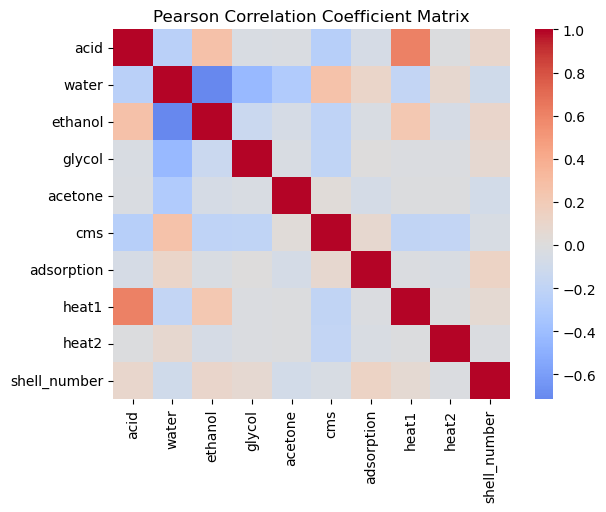

In [3]:
from data_analysis import plt_pearsonr
plt_pearsonr(df.iloc[:,-10:])

### 分割数据

In [4]:
random_state = 11
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape, y_train.shape)
print(y_train.value_counts())

(252, 34) (252,)
shell_number
1    190
0     62
Name: count, dtype: int64


In [5]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=random_state)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
print(x_resampled.shape, y_resampled.shape)
print(y_resampled.value_counts())

(380, 34) (380,)
shell_number
1    190
0    190
Name: count, dtype: int64


### 常用模型构建

In [6]:

# 神经网络模型
mlp = MLPClassifier(
    activation='relu',
    solver='adam', 
    hidden_layer_sizes=(4), 
    max_iter=1000,
    random_state=random_state
)
# 随机森林模型
rf = RandomForestClassifier(random_state=random_state)
# 梯度提升树模型
gbdt = GradientBoostingClassifier(random_state=random_state)
# 支持向量机
svc = SVC(random_state=random_state)
# k-近邻方法
knn = KNeighborsClassifier()

models = {
    'mlp':mlp,
    'rf':rf,
    'gbdt':gbdt,
    'svc':svc,
}

In [7]:
from evaluate import model_evaluate
for name, model in models.items():
    print('***********************')
    print(f'model: {name}')
    model_evaluate(x_resampled, y_resampled, x_test, y_test, model)
print('***********************')

***********************
model: mlp
accuracy:0.609375, recall:0.6382978723404256, precision:0.7894736842105263, f1:0.7058823529411765 
confusion matrix:
 [[ 9  8]
 [17 30]]
***********************
model: rf
accuracy:0.671875, recall:0.7659574468085106, precision:0.782608695652174, f1:0.7741935483870968 
confusion matrix:
 [[ 7 10]
 [11 36]]
***********************
model: gbdt
accuracy:0.6875, recall:0.7659574468085106, precision:0.8, f1:0.782608695652174 
confusion matrix:
 [[ 8  9]
 [11 36]]
***********************
model: svc
accuracy:0.578125, recall:0.5957446808510638, precision:0.7777777777777778, f1:0.6746987951807228 
confusion matrix:
 [[ 9  8]
 [19 28]]
***********************


In [8]:
from sklearn.model_selection import cross_validate, StratifiedKFold

skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=2)
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall_macro',
    'precision': 'precision_macro',
    'f1': 'f1_macro',
}

results = {}
for name, model in models.items():
    eva = {}
    cv_results = cross_validate(model, x, y, cv=skf, scoring=scoring)
    eva['accuracy'] = cv_results['test_accuracy'].mean()
    eva['recall'] = cv_results['test_recall'].mean()
    eva['precision'] = cv_results['test_precision'].mean()
    eva['f1'] = cv_results['test_f1'].mean()
    results[name] = eva

results_df = pd.DataFrame(results)
display(results_df)


,mlp,rf,gbdt,svc
accuracy,0.737298,0.705544,0.743448,0.750000
recall,0.491486,0.562668,0.596894,0.500000
precision,0.373333,0.584633,0.641985,0.375000
f1,0.424313,0.560684,0.604392,0.428557
